# Problema 1 Grupo 8
Tenemos que generar la tabla de la normal estándar $N(0,1)$. Para ello dividiremos este problema en tres partes:

1. La implementación del algoritmo de Ziggurat.
2. La aplicación de contrastes para asegurar que generamos la normal estándar.
3. La creación de la tabla normal estandar y comparación con la implementación de numpy.

Para la ejecución del siguiente código se requieren las siguientes librerías:
- **numpy** para la implementación del algoritmo.
- **pandas** para guardar la tabla y poder exportarlo luego.
- **scipy** para los contrastes y demás datos estadísticos.
- **matplorlib** para mostrar diferentes gráficos.
 
Antes del código hay una sección de *Contexto* con las explicaciones del algoritmo y algún detalle de la implementación. En caso de haber leído el latex de la entrega se puede saltar esta parte, pero es una buena explicación para aquellos que no posean este deocumento.

## Referencias
Esta implementación se basa en dos fuentes distintas, una para el algoritmo completo y otra para el tratamiento de la cola:
- Marsaglia, G., & Tsang, W. W. (2000). The ziggurat method for generating random variables. Journal of Statistical Software, 5(8), 1–7.
- Marsaglia, G. (1963). Generating a variable from the tail of the normal distribution (Mathematical Note No. 322). Boeing Scientific Research Laboratories.

## Contexto
### Precálculo
Partimos de nuestro conjunto $C$ que es el área bajo la curva $y=f(x)=e^{-x^2/2}$ (mitad positiva de la normal estándar).  
La idea es generar un área $Z$ tal que $Z \supset C$, este área la conformamos por un conjunto $N$ de cajas con mismo área $v$.  
Para maximizar la eficiencia se busca que $N$ sea un múltiplo de 2, de tal manera que se pueda aprovechar la estructura binaria de los ordenadores, y poder así tomar valores truncando ciertos bits.  
En este caso usaremos **128 cajas** para la mitad positiva de la normal estándar. Posteriormente reflejaremos los valores para cubrir la distribución completa $N(0,1)$.

Para generar las cajas en base a nuestro $N$ debemos seguir una relación concreta: **todas** las cajas deben tener área $v$. Definimos las cajas tal que:
$$
x_0 = 0 < x_1 < x_2 < ... < x_N = r
$$
$$
v = x_i [f(x_{i-1}) - f(x_i)] \qquad i= 1, 2, ..., N
$$
Esto se define así para todas las cajas, pero para el caso $x_N = r$ no solo contiene la caja, contiene además el área de la cola de la función decreciente, tal que:
$$
v = r f(r) +  \int_{r}^{\infty} f(x)\,dx
$$

#### Cálculo de $r$
Como se puede ver, aún teniendo $v$ dado, este depende de $r$, por lo que los investigadores nos han proporcionado la función $z(r)$ que nos permite ver si el valor de $r$ que estamos utilizando cumple con las definiciones y todas las cajas que genera tienen área $v$. Esta función se define como:

*Algorithm: $z(r)$ para el cálculo del valor óptimo de $r$*  

*Input:*  
$f(x)$ (densidad decreciente),  
$f^{-1}(y)$ (inversa de $f$),  
$N$ (número de rectángulos).  

*Output:*  
$z(r)$ (valor que debe anularse para obtener el $r$ correcto).  

---

1. $( x_N \leftarrow r )$

2. $( v \leftarrow r\,f(r) + \displaystyle\int_{r}^{\infty} f(x)\,dx )$

3. *for* $i = N-1, N-2, \dots, 1$ 
   
   *do:*  
   $\quad x_i \leftarrow f^{-1}\!\left(f(x_{i+1}) + \dfrac{v}{x_{i+1}}\right ) $

4. *return* $z(r) = v - \left(x_1 - x_1 f(x_1)\right) $

---

En este ejercicio trabajaremos únicamente con la **distribución normal estándar**, por lo que no calcularemos el valor de $r$ ni el área $v$ de forma numérica.  
Para simplificar el trabajo, utilizaremos directamente los valores del trabajo original de *Marsaglia y Tsang (2000), “The Ziggurat Method for Generating Random Variables”*, y nos permiten concentrarnos en la comprensión del método sin añadir complejidad innecesaria en el cálculo de $r$ y $v$.

**Normal estándar (mitad positiva, $N=128$)**  
$$
f(x) = e^{-x^2/2}, \quad x \ge 0
$$
Se usa únicamente la mitad positiva de la normal estándar (sin constante de normalización).  
Para obtener la distribución completa $ N(0,1) $, basta con asignar un signo aleatorio $ \pm1 $ con probabilidad $ 1/2 $.  
En este caso se utilizan **128 rectángulos (N = 128)**, con los valores:
$$
r = 3.442619855899, \qquad
v = 0.00991256303526217
$$
La eficiencia del método con estos parámetros es del **98.78 %**.

#### Cálculo de las cajas
En este punto ya tenemos $r$, ya conocemos la relación entre una caja y la anterior y conocemos las restricciones ($v$) de estas cajas, solo tenemos que invertir la función para conseguir calcular todas las cajas:
$$
f(x_{i-1}) = f(x_i) + \frac{v}{x_i}
$$
$$
x_{i-1} = f^{-1}(f(x_i) + \frac{v}{x_i})
$$

##### Tablas precalculadas `k`, `w`, `f`

Para optimizar el proceso de generación, se precalculan tres tablas que permiten aceptar aproximadamente el **99 %** de las muestras sin necesidad de evaluar exponenciales.

- **Tabla $f$**  
  Guarda las alturas de la función en los bordes de las cajas:
  $$
  f_i = e^{-\xi_i^2/2}, \quad i=0,\dots,N
  $$
  De esta forma, en la ruta lenta basta una sola evaluación de $f(x)$ para decidir la aceptación:
  $$
  f_i + U(f_{i-1}-f_i) < f(x)
  $$

- **Tabla $w$**  
  Escala los enteros de 31 bits:
  $$
  M = 2^{31}, \qquad w_i = \frac{\xi_i}{M}
  $$
  Garantiza que $x = hz \cdot w_i \in [-\xi_i, +\xi_i]$.

- **Tabla $k$**  
  Define los umbrales para el test rápido de aceptación:
  $$
  k_i = \left\lfloor M \cdot \frac{\xi_{i-1}}{\xi_i} \right\rfloor
  $$
  Si se cumple $|hz| < k_i$, el punto se acepta directamente, ya que cae bajo la curva:
  $$
  |hz| < k_i \Rightarrow x = hz \cdot w_i
  $$

##### Caja base ($i=0$)

La primera caja ($i=0$) es especial porque limita con la cola ($x>r$).  
Se impone que su área sea igual al resto:
$$
q\,f(r) = v \;\;\Longrightarrow\;\; q = \frac{v}{f(r)}
$$
De este modo:
$$
w_0 = \frac{q}{M}, \qquad
k_0 = \left\lfloor \frac{r}{q}\,M \right\rfloor, \qquad
f_0 = f(0) = 1
$$

##### Tratamiento de la cola ($i = 0$)

En la distribución normal estándar, la densidad decrece rápidamente:

$$
f(x) = e^{-x^2/2}
$$

Para $x > r$, el valor de $f(x)$ es muy pequeño, pero esta región no puede ignorarse, ya que contribuye al área total bajo la curva.  
Por ello se utiliza el método propuesto por **Marsaglia (1963)**, que permite generar muestras en la cola derecha de manera eficiente mediante aceptación-rechazo.

**Algoritmo (Marsaglia, 1963):**

1. Generar $U_1, U_2 \sim \mathcal{U}(0,1)$  
2. Calcular:
   $$
   x_\Delta \leftarrow \frac{-\ln U_1}{r}, \qquad Y \leftarrow -\ln U_2
   $$
3. Aceptar si:
   $$
   2Y > (x_\Delta)^2
   $$
4. Si se cumple, devolver:
   $$
   x = r + x_\Delta
   $$
   En caso contrario, repetir desde el paso 1.

Este criterio geométrico garantiza que el punto $(x, f(x))$ se encuentra bajo la curva de densidad truncada.  
La probabilidad de rechazo es muy baja (≈10–12 %), por lo que la eficiencia es muy alta.

#### Integración con el algoritmo principal

Cuando el índice de caja es $i = 0$:

1. Se genera un punto en el rectángulo base de altura $f(r)$ y anchura $q$.  
2. Si el punto cae fuera del rectángulo, se entra en la **cola** aplicando el algoritmo anterior.  
3. Finalmente, para obtener la distribución completa $N(0,1)$, se asigna un signo aleatorio con probabilidad $0.5$:
   $$
   x \leftarrow \pm x
   $$

#### Observaciones

- La cola derecha generada con este método sigue exactamente la distribución proporcional a $e^{-x^2/2}$ para $x>r$.  
- El rechazo ocurre con baja frecuencia, manteniendo la eficiencia global del método Ziggurat por encima del **98.7 %**.


### Generador base

El método utiliza un generador uniforme de **32 bits** (p. ej. **SHR3**) con buena distribución de bits bajos y periodo $2^{32}-1$.  
Esto permite indexar cajas con los bits menos significativos y calcular candidatos con desplazamientos y multiplicaciones simples.

En nuestro caso usamos **Mersenne Twister** de NumPy por disponibilidad y periodo muy largo.

---

### Algoritmo Generador (normal, mitad positiva, $N=128$)

1. Generar un entero de 32 bits $hz$.
2. Índice de caja:
   $$
   i \leftarrow hz \;\&\; (N-1)
   $$
3. Candidato (convención $M=2^{31}$):
   $$
   x \leftarrow |hz|\cdot w[i], \qquad w[i]=\frac{x_i}{2^{31}}
   $$
4. **Test rápido**:
   $$
   \text{si}\; |hz|<k[i]\; \Rightarrow\; \text{aceptar } x
   $$
5. **Caso cola ($i=0$)**:
   1) Generar $U_1,U_2\sim\mathcal U(0,1)$  
   2) $x_\Delta \leftarrow \dfrac{-\ln U_1}{r}$,\; $Y\leftarrow -\ln U_2$  
   3) Aceptar si $2Y>(x_\Delta)^2$; devolver $x=r+x_\Delta$; si no, repetir 5).
6. **Caja interna ($i>0$)**:
   $$
   \text{aceptar si } f(x) > f_i + \frac{f_{i-1}-f_i}{x_i-x_{i-1}}(x-x_i), \quad f(x)=e^{-x^2/2}
   $$
   Si falla, volver a 1).
7. **Simetría** para $N(0,1)$:
   $$
   x \leftarrow \pm x \quad \text{con prob. } 0.5
   $$
8. Devolver $x$.

---


## Implementación
A continuación hay un bloque que instala las librerias necesarias para ejecutar el código, en caso de ya tener las librerías se puede comentar.

In [2]:
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install pandas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time
import pandas as pd

## Implementación del Algoritmo de Ziggurat

In [4]:
def generar_capas(n_capas: int = 128, 
                  r: float = 3.442619855899, 
                  v: float = 9.91256303526217e-3) -> np.ndarray:
    """
    Calcula los bordes x_i de las capas del ziggurat para la normal estándar (lado positivo).
    
    Implementación basada en Marsaglia & Tsang (2000), sección 3.
    
    Args:
        n_capas: Número de capas (típicamente 64, 128, o 256)
        r: Borde derecho (x_{N-1}), del paper
        v: Área común de cada rectángulo, del paper
    
    Returns:
        Array de forma (n_capas,) con los bordes:
        - x_list[0] = 0 (borde izquierdo)
        - x_list[i] = borde derecho de la capa i
        - x_list[-1] = r (borde de la cola)
    """
    # Función densidad sin normalizar, es decir, sin 1/sqrt(2*pi) (lado positivo de N(0,1))
    f = lambda x: np.exp(-0.5 * x * x)
    
    # Inversa de f: f^{-1}(y) = sqrt(-2 * ln(y))
    f_inv = lambda y: np.sqrt(-2.0 * np.log(y))
    
    # Array de bordes (x_0, x_1, ..., x_{N-1})
    x_list = np.zeros(n_capas, dtype=np.float64)
    x_list[-1] = r  # x_{N-1} = r (borde de la cola)
    
    # Iteración hacia atrás: x_i = f^{-1}(v/x_{i+1} + f(x_{i+1}))
    # Basado en la relación: x_i * [f(x_{i-1}) - f(x_i)] = v
    for i in range(n_capas - 2, 0, -1):
        y = f(x_list[i + 1]) + v / x_list[i + 1]
        x_list[i] = f_inv(y)
    
    # x_0 es el borde izquierdo (siempre 0)
    x_list[0] = 0.0
    
    return x_list

In [5]:
def generar_tablas_precalculadas(x_list: np.ndarray, v: float):
    """
    Construye las tablas k, w, f del Ziggurat para optimizar la generación.
    
    Estas tablas permiten que el test rápido (paso 2 del algoritmo) se ejecute
    con solo 2 accesos a memoria y 1 comparación de enteros.
    
    Tablas generadas:
    - k[i]: Umbral entero para el test rápido (uint32)
    - w[i]: Factor de escala para convertir entero → float (float64)
    - f[i]: Valores precalculados de la densidad f(x_i) (float64)
    
    Args:
        x_list: Array con los bordes x_i de las capas (longitud N)
        v: Área común de cada rectángulo
    
    Returns:
        (k_list, w_list, f_list): Tupla con las tres tablas
    
    Notas sobre el diseño:
    - M = 2^31 porque trabajamos con 31 bits de magnitud (1 bit para signo)
    - La capa i=0 es especial: combina rectángulo base + cola infinita
    """
    x_list = np.asarray(x_list, dtype=np.float64)
    N = x_list.size
    
    if N < 2:
        raise ValueError("Se requieren al menos 2 bordes: x_0≈0 y x_{N-1}=r.")

    # Tablas a rellenar
    f_list = np.exp(-0.5 * x_list * x_list)
    k_list = np.zeros(N, dtype=np.uint32)
    w_list = np.zeros(N, dtype=np.float64)

    # Escala entera M = 2^31 (magnitud de 31 bits)
    M = float(1 << 31)

    # (A) Filas i>=1: relaciones directas entre bordes adyacentes
    w_list[1:] = x_list[1:] / M
    with np.errstate(divide="ignore", invalid="ignore"):
        # Calcular ratio x_{i-1} / x_i para todas las capas
        ratio = x_list[:-1] / x_list[1:]
        # Manejar casos donde x_i podría ser 0 (solo x_0 en realidad)
        ratio = np.where(x_list[1:] > 0, ratio, 0.0)
    # Escalar a enteros y truncar: k[i] = floor(M * ratio)
    k_list[1:] = np.floor(M * ratio).astype(np.uint32)

    # (B) Fila i=0 (base + cola): usa q = v / f(r)
    r = x_list[-1]
    fr = np.exp(-0.5 * r * r)

    if fr <= 0.0:
        raise ValueError("f(r) es 0")
    
    q = v / fr
    k_list[0] = np.uint32(np.floor((r / q) * M))
    w_list[0] = q / M

    return k_list, w_list, f_list

In [6]:
def cola_normal(r: float, rng: np.random.Generator, u1_inicial: float = None) -> float:
    """
    Genera un valor de la cola derecha de N(0,1) (x > r).
    Usa el método de Marsaglia (1963) optimizado.
    
    Este método transforma la cola exponencial en el intervalo unitario
    y aplica rechazo para generar valores > r de la normal.
    
    Args:
        r: límite de la cola (típicamente r ≈ 3.44 para N=128)
        rng: generador de números aleatorios
        u1_inicial: primer uniforme
    
    Returns:
        float: valor x > r siguiendo la cola de N(0,1)
    """

    # Primera iteración: reutilizar u1_inicial si está disponible
    # Esto ahorra una llamada al RNG cuando venimos del test rápido fallido
    u1 = u1_inicial if u1_inicial is not None else rng.random()
    
    while True:
        # Generar segundo uniforme
        u2 = rng.random()

        # Transformación de Marsaglia (1963)
        x = -np.log(u1) / r
        y = -np.log(u2)
        
        # Test de aceptación de Marsaglia:
        # Aceptar si 2*y > x², equivalente a y+y > x*x
        # Esto acepta puntos bajo la curva exp(-x²/2) en la cola
        # Eficiencia: ~88% de aceptación para r=3.44
        if (y + y) > (x * x):
            return r + x
        
        # Rechazado: genera nuevo u1 para siguiente iteración
        u1 = rng.random()

In [7]:
def ziggurat_norm_one(
    rng: np.random.Generator,
    k: np.ndarray,        # uint32, shape (N,)
    w: np.ndarray,        # float64, shape (N,)
    f: np.ndarray,        # float64, shape (N,), f[i]=exp(-xi[i]^2/2)
    xi: np.ndarray,       # float64, shape (N,), bordes lado positivo
    r: float              # límite derecho (xi[-1])
) -> float:
    """
    Genera UNA muestra ~ N(0,1) usando el método Ziggurat (Marsaglia & Tsang, 2000),
    con tablas precalculadas (k, w, f, xi). Devuelve un float.
    
    Usa uint32 y operaciones bit a bit para extraer signo e índice.
    Magnitud de 31 bits (bit 31 es el signo).

    Reglas:
      - Test rápido: mag < k[i]  -> x = ±mag * w[i] (aceptado)
      - Si i == 0 y falla: cola (x>r) con Marsaglia 1963; aplicar signo
      - Si i > 0 y falla: tiras (rechazo local) con alturas tabuladas f[i-1], f[i]
    """
    
    while True:
        # 1) Un entero de 32 bits SIN signo
        u = rng.integers(0, 1 << 32, dtype=np.uint32, endpoint=False)
        
        # 2) Índice (7 bits bajos) y signo (MSB, bit 31)
        iz = int(u & np.uint32(0x7F))  # 0..127
        sign = -1.0 if (u & np.uint32(0x80000000)) else 1.0
        
        # 3) Magnitud en 31 bits completos (sin el bit de signo)
        mag = u & np.uint32(0x7FFFFFFF)  # 0..(2^31-1)
        
        # 4) Test rápido: mag < k[iz] ?
        if mag < k[iz]:
            # Acepta inmediatamente
            return sign * (float(mag) * float(w[iz]))
        
        # 5) COLA (iz == 0): genera valor > r usando el método de Marsaglia
        if iz == 0:
            # Convertir magnitude a uniforme [0,1) coherente con M = 2^31
            u1_inicial = float(mag) * (1.0 / float(1 << 31))
            x_tail = cola_normal(r, rng, u1_inicial)
            return sign * x_tail
        
        # 6) TIRAS (iz > 0): usa magnitud para formar x
        x_abs = float(mag) * float(w[iz])
        x = sign * x_abs
        
        # Genera UN solo uniforme para el test de rechazo
        u = rng.random()
        
        # Test: f[iz-1] - f[iz] * U < f(x) - f[iz]
        # Equivalente a: [f(x_{i-1}) - f(x_i)] * U < f(x) - f(x_i)
        # (ver paso 4 del algoritmo en la página 3 del paper)
        lhs = (float(f[iz - 1]) - float(f[iz])) * u
        rhs = np.exp(-0.5 * x * x) - float(f[iz])
        
        if lhs < rhs:
            return x
        
        # Si rechaza, el while True reinicia con nuevo u

In [8]:
def generar_muestras_ziggurat(n_muestras: int, seed: int = 42) -> np.ndarray:
    """
    Genera n_muestras usando el método Ziggurat.
    
    Args:
        n_muestras: Cantidad de números aleatorios a generar
        seed: Semilla para reproducibilidad
    
    Returns:
        Array de forma (n_muestras) con valores ~ N(0,1)
    """
    # 1. Inicializar generador
    mt = np.random.MT19937(seed=seed)
    rng = np.random.Generator(mt)
    
    # 2. Generar capas y tablas (solo una vez)
    print("Inicializando Ziggurat...")
    r = 3.442619855899
    v = 9.91256303526217e-3
    x_list = generar_capas(n_capas=128, r=r, v=v)
    k, w, f = generar_tablas_precalculadas(x_list, v)
    print(f"Tablas generadas para {len(x_list)} capas")
    
    # 3. Generar muestras
    print(f"Generando {n_muestras:,} muestras...")
    start_time = time.time()
    
    muestras = np.array([ziggurat_norm_one(rng, k, w, f, x_list, r) 
                        for _ in range(n_muestras)])
    
    elapsed = time.time() - start_time
    print(f"Generadas en {elapsed:.3f} segundos ({n_muestras/elapsed:,.0f} muestras/seg)")
    
    return muestras

## Aplicación de contrastes para asegurar que generamos la normal estándar.

### Contrastes estadísticos aplicados a las muestras

En esta sección se evalúa si las muestras generadas siguen una distribución normal estándar $N(0,1)$, contrastando tres hipótesis nulas independientes: una sobre la **media**, otra sobre la **varianza** y otra sobre la **normalidad**.  
En todos los casos se adopta un nivel de significación $\alpha = 0.05$ y se utilizan las funciones estadísticas del módulo `scipy.stats`.

---

#### Test t de Student (contraste sobre la media)

**Objetivo:** comprobar si la media poblacional es igual a cero.  
Se plantea el contraste:
$$
H_0: \mu = 0 \qquad \text{vs} \qquad H_1: \mu \neq 0
$$

**Estadístico de contraste:**
$$
t = \frac{\bar{x} - \mu_0}{s / \sqrt{n}}
$$
donde $\bar{x}$ es la media muestral y $s^2$ la varianza muestral.  
Bajo $H_0$, el estadístico $t$ sigue una distribución $t_{n-1}$ con $n-1$ grados de libertad.

El cálculo se realiza con la función:

```
stats.ttest_1samp(muestras, 0.0)
```

El p-valor se obtiene como:
$$
p = 2\,[\,1 - F_t(|t|; n-1)\,]
$$

**Decisión:**
$$
\text{Si } p > 0.05 \Rightarrow \text{no se rechaza } H_0
\quad ; \quad
\text{si } p \le 0.05 \Rightarrow \text{se rechaza } H_0
$$

Interpretación: si no se rechaza $H_0$, la media muestral no difiere significativamente de 0.

---

#### Test Chi-cuadrado (contraste sobre la varianza)

**Objetivo:** comprobar si la varianza poblacional es igual a 1.  
Se plantea:
$$
H_0: \sigma^2 = 1 \qquad \text{vs} \qquad H_1: \sigma^2 \neq 1
$$

**Estadístico de contraste:**
$$
\chi^2 = \frac{(n - 1) s^2}{\sigma_0^2}
$$

Bajo $H_0$, el estadístico $\chi^2$ sigue una distribución $\chi^2_{(n-1)}$.  
Dado que la prueba es bilateral, el p-valor se calcula como:
$$
p = 2\,\min\!\left( F_{\chi^2}(\chi^2; n-1),\; 1 - F_{\chi^2}(\chi^2; n-1) \right)
$$

En el código se implementa así:

```
chi2_stat = (n - 1) * varianza / 1.0  
p_value = 2 * min(stats.chi2.cdf(chi2_stat, n-1),  
                  1 - stats.chi2.cdf(chi2_stat, n-1))
```

**Decisión:**
$$
\text{Si } p > 0.05 \Rightarrow \text{no se rechaza } H_0
\quad ; \quad
\text{si } p \le 0.05 \Rightarrow \text{se rechaza } H_0
$$

Interpretación: si no se rechaza $H_0$, la varianza muestral es estadísticamente igual a 1.

---

#### Test de Kolmogorov-Smirnov (contraste de normalidad)

**Objetivo:** verificar si las muestras siguen una distribución normal estándar $N(0,1)$.  
Se contrasta:
$$
H_0: X \sim N(0,1) \qquad \text{vs} \qquad H_1: X \not\sim N(0,1)
$$

**Estadístico de contraste:**
$$
D = \sup_x | F_n(x) - F(x) |
$$
donde $F_n(x)$ es la función de distribución acumulada empírica y $F(x)$ la acumulada teórica de $N(0,1)$.

El cálculo se realiza con la función:

```
stats.kstest(muestras, 'norm')
```

El p-valor se obtiene a partir de la distribución asintótica de Kolmogorov para $D$.

**Decisión:**
$$
\text{Si } p > 0.05 \Rightarrow \text{no se rechaza } H_0
\quad ; \quad
\text{si } p \le 0.05 \Rightarrow \text{se rechaza } H_0
$$

Interpretación: no rechazar $H_0$ implica que las muestras no presentan desviaciones significativas respecto a la distribución normal estándar.

---

#### Conclusión general

Si en los tres contrastes no se rechazan las hipótesis nulas al nivel $\alpha = 0.05$, se puede concluir que las muestras son **estadísticamente compatibles con una distribución $N(0,1)$**.


In [9]:
def realizar_tests_estadisticos(muestras: np.ndarray):
    """
    Realiza tests estadísticos sobre las muestras generadas.
    
    Tests incluidos:
    - Estadísticos descriptivos básicos
    - Test t de Student para la media
    - Test Chi-cuadrado para la varianza
    - Test Kolmogorov-Smirnov para normalidad
    """
    n = len(muestras)
    print("\n" + "="*70)
    print(f"TESTS ESTADÍSTICOS (n = {n:,} muestras)")
    print("="*70)
    
    # 1. Estadísticos básicos
    media = np.mean(muestras)
    varianza = np.var(muestras, ddof=1)  # ddof=1 para varianza muestral
    desviacion = np.std(muestras, ddof=1)
    
    print(f"\n1. ESTADÍSTICOS DESCRIPTIVOS:")
    print(f"   Media:              {media:12.8f}  (esperado: 0.0)")
    print(f"   Varianza:           {varianza:12.8f}  (esperado: 1.0)")
    print(f"   Desviación estándar:{desviacion:12.8f}  (esperado: 1.0)")
    print(f"   Mínimo:             {np.min(muestras):12.8f}")
    print(f"   Máximo:             {np.max(muestras):12.8f}")
    print(f"   Asimetría:          {stats.skew(muestras):12.8f}  (esperado: ~0.0)")
    print(f"   Curtosis:           {stats.kurtosis(muestras):12.8f}  (esperado: ~0.0)")
    
    # 2. Test t de Student para la media (H₀: μ = 0)
    print(f"\n2. TEST t DE STUDENT (H₀: μ = 0):")
    print(f"   Contrasta si la media muestral es estadísticamente igual a 0.")
    t_stat, p_value_media = stats.ttest_1samp(muestras, 0.0)
    print(f"   Estadístico t:      {t_stat:12.8f}")
    print(f"   p-valor:            {p_value_media:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_media > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       La media muestral es estadísticamente igual a 0")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       La media muestral difiere significativamente de 0")
    
    # 3. Test Chi-cuadrado para la varianza (H₀: σ² = 1)
    print(f"\n3. TEST CHI-CUADRADO (H₀: σ² = 1):")
    print(f"   Contrasta si la varianza muestral es estadísticamente igual a 1.")
    chi2_stat = (n - 1) * varianza / 1.0
    p_value_var = 2 * min(stats.chi2.cdf(chi2_stat, n-1), 
                          1 - stats.chi2.cdf(chi2_stat, n-1))
    print(f"   Estadístico χ²:     {chi2_stat:12.2f}")
    print(f"   Grados de libertad: {n-1}")
    print(f"   p-valor:            {p_value_var:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_var > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       La varianza muestral es estadísticamente igual a 1")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       La varianza muestral difiere significativamente de 1")
    
    # 4. Test de Kolmogorov-Smirnov para normalidad (H₀: muestras ~ N(0,1))
    print(f"\n4. TEST KOLMOGOROV-SMIRNOV (H₀: muestras ~ N(0,1)):")
    print(f"   Contrasta si las muestras siguen una distribución normal estándar.")
    print(f"   Compara la función de distribución acumulada empírica con la teórica.")
    ks_stat, p_value_ks = stats.kstest(muestras, 'norm')
    print(f"   Estadístico D:      {ks_stat:12.8f}")
    print(f"   p-valor:            {p_value_ks:12.8f}")
    print(f"   Interpretación:     ", end="")
    if p_value_ks > 0.05:
        print(f"✓ No se rechaza H₀ (α=0.05)")
        print(f"                       Las muestras siguen una distribución N(0,1)")
    else:
        print(f"✗ Se rechaza H₀ (α=0.05)")
        print(f"                       Las muestras NO siguen una distribución N(0,1)")
    
    print("\n" + "="*70)

In [10]:
def visualizar_resultados(muestras: np.ndarray, guardar: bool = True):
    """
    Crea visualizaciones para validar la normalidad de las muestras.
    """
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Histograma vs densidad teórica
    ax1 = plt.subplot(2, 3, 1)
    counts, bins, _ = ax1.hist(muestras, bins=100, density=True, alpha=0.7, 
                                color='steelblue', edgecolor='black', linewidth=0.5)
    x_plot = np.linspace(-4, 4, 1000)
    ax1.plot(x_plot, stats.norm.pdf(x_plot, 0, 1), 'r-', lw=2.5, 
             label='N(0,1) teórica')
    ax1.set_xlabel('Valor', fontsize=11)
    ax1.set_ylabel('Densidad', fontsize=11)
    ax1.set_title('Histograma vs Densidad Teórica', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Q-Q plot
    ax2 = plt.subplot(2, 3, 2)
    stats.probplot(muestras, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. CDF empírica vs teórica
    ax3 = plt.subplot(2, 3, 3)
    x_sorted = np.sort(muestras)
    y_empirica = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
    ax3.plot(x_sorted, y_empirica, 'b-', lw=1.5, label='CDF empírica', alpha=0.7)
    ax3.plot(x_plot, stats.norm.cdf(x_plot, 0, 1), 'r-', lw=2, 
             label='CDF teórica N(0,1)')
    ax3.set_xlabel('Valor', fontsize=11)
    ax3.set_ylabel('Probabilidad acumulada', fontsize=11)
    ax3.set_title('CDF Empírica vs Teórica', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # 4. Serie temporal (primeras 1000 muestras)
    ax4 = plt.subplot(2, 3, 4)
    n_plot = min(1000, len(muestras))
    ax4.plot(range(n_plot), muestras[:n_plot], 'b-', lw=0.8, alpha=0.7)
    ax4.axhline(y=0, color='r', linestyle='--', lw=1.5, alpha=0.7)
    ax4.axhline(y=1, color='orange', linestyle='--', lw=1, alpha=0.5)
    ax4.axhline(y=-1, color='orange', linestyle='--', lw=1, alpha=0.5)
    ax4.set_xlabel('Índice', fontsize=11)
    ax4.set_ylabel('Valor', fontsize=11)
    ax4.set_title(f'Serie Temporal (primeras {n_plot} muestras)', 
                  fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 5. Boxplot
    ax5 = plt.subplot(2, 3, 5)
    bp = ax5.boxplot(muestras, vert=True, patch_artist=True, widths=0.5)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax5.axhline(y=0, color='r', linestyle='--', lw=1.5, alpha=0.7, label='μ = 0')
    ax5.set_ylabel('Valor', fontsize=11)
    ax5.set_title('Boxplot', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.legend(fontsize=10)
    
    # 6. Estadísticos en texto
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    media = np.mean(muestras)
    varianza = np.var(muestras, ddof=1)
    desv = np.std(muestras, ddof=1)
    
    texto = f"""
    ESTADÍSTICOS PRINCIPALES
    {'='*35}
    
    Tamaño muestral:    {len(muestras):,}
    
    Media:              {media:.6f}
    Desviación estándar: {desv:.6f}
    Varianza:           {varianza:.6f}
    
    Mínimo:             {np.min(muestras):.6f}
    Q1 (25%):           {np.percentile(muestras, 25):.6f}
    Mediana (50%):      {np.percentile(muestras, 50):.6f}
    Q3 (75%):           {np.percentile(muestras, 75):.6f}
    Máximo:             {np.max(muestras):.6f}
    
    Asimetría:          {stats.skew(muestras):.6f}
    Curtosis:           {stats.kurtosis(muestras):.6f}
    """
    
    ax6.text(0.1, 0.5, texto, fontsize=10, verticalalignment='center',
             fontfamily='monospace', bbox=dict(boxstyle='round', 
             facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    
    if guardar:
        plt.savefig('ziggurat_validacion.png', dpi=300, bbox_inches='tight')
        print(f"\n✓ Gráfico guardado como 'ziggurat_validacion.png'")
    
    plt.show()

Inicializando Ziggurat...
Tablas generadas para 128 capas
Generando 1,000,000 muestras...
Generadas en 1.730 segundos (578,047 muestras/seg)

TESTS ESTADÍSTICOS (n = 1,000,000 muestras)

1. ESTADÍSTICOS DESCRIPTIVOS:
   Media:                0.00029240  (esperado: 0.0)
   Varianza:             0.99907937  (esperado: 1.0)
   Desviación estándar:  0.99953958  (esperado: 1.0)
   Mínimo:              -3.46432981
   Máximo:               3.46447909
   Asimetría:           -0.00316694  (esperado: ~0.0)
   Curtosis:            -0.02171123  (esperado: ~0.0)

2. TEST t DE STUDENT (H₀: μ = 0):
   Contrasta si la media muestral es estadísticamente igual a 0.
   Estadístico t:        0.29253090
   p-valor:              0.76988080
   Interpretación:     ✓ No se rechaza H₀ (α=0.05)
                       La media muestral es estadísticamente igual a 0

3. TEST CHI-CUADRADO (H₀: σ² = 1):
   Contrasta si la varianza muestral es estadísticamente igual a 1.
   Estadístico χ²:        999078.37
   Grados 

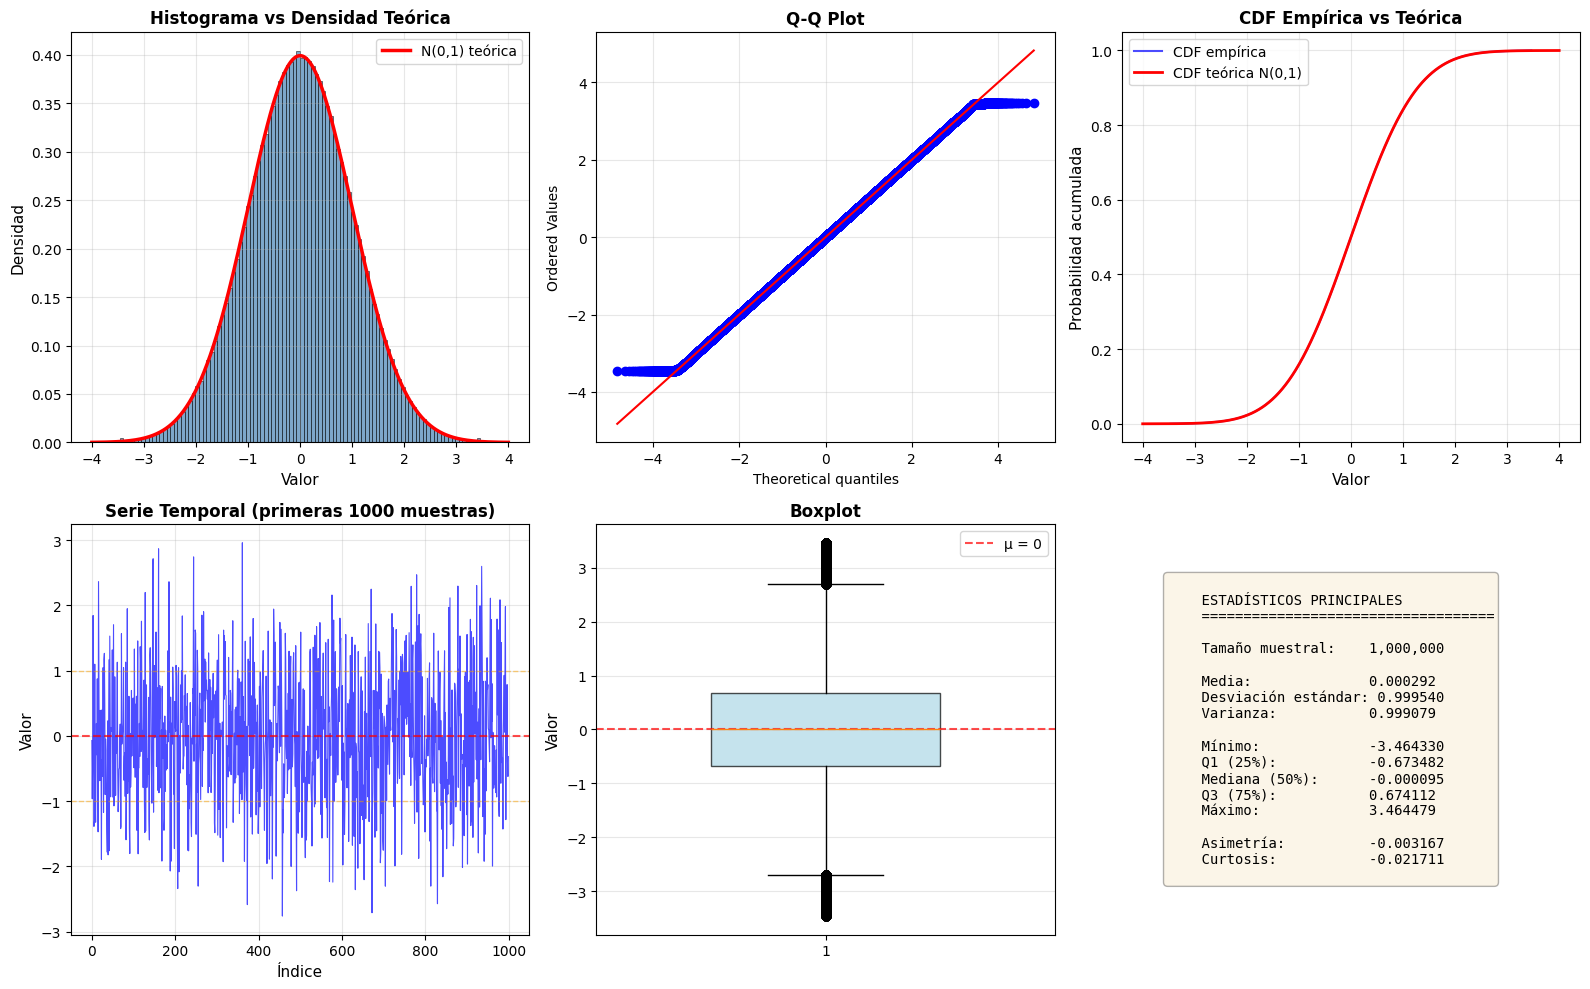

In [11]:
N_MUESTRAS = 1000000

muestras = generar_muestras_ziggurat(n_muestras=N_MUESTRAS, seed=42)

realizar_tests_estadisticos(muestras)
visualizar_resultados(muestras, guardar=True)

## Generación de la tabla de la normal estándar

En este apartado construimos una tabla de la distribución normal estándar utilizando las muestras generadas con nuestro algoritmo y la comparamos con los valores teóricos obtenidos mediante scipy.stats.norm.

### Procedimiento

1. Ordenamos las muestras generadas.
2. Definimos un rango de valores z entre -3.9 y 3.9 con un paso de 0.01.
3. Para cada z calculamos:
   - La CDF empírica mediante np.searchsorted.
   - La CDF teórica mediante stats.norm.cdf(z).
4. Obtenemos el error absoluto entre ambas.
5. Guardamos el resultado en una tabla con las columnas: z, P(Z≤z)_empirica, P(Z≤z)_teorica y error.

### Resultados

- Se muestran el error máximo y promedio.
- Se representan dos gráficos: la CDF empírica frente a la teórica y el error absoluto en todo el rango.

### Exportación

Además, generamos una tabla clásica en formato texto con los valores acumulados típicos de un z-score con dos decimales.



In [23]:
def generar_tabla_normal(muestras: np.ndarray, z_min: float = -3.9, 
                        z_max: float = 3.9, paso: float = 0.01) -> pd.DataFrame:
    """Genera tabla P(Z ≤ z) a partir de muestras."""
    muestras_ordenadas = np.sort(muestras)
    n = len(muestras)
    z_valores = np.arange(z_min, z_max + paso, paso)
    
    prob_empirica = np.array([np.searchsorted(muestras_ordenadas, z, side='right') / n 
                             for z in z_valores])
    prob_teorica = stats.norm.cdf(z_valores)
    
    return pd.DataFrame({
        'z': z_valores,
        'P(Z≤z)_empirica': prob_empirica,
        'P(Z≤z)_teorica': prob_teorica,
        'error': np.abs(prob_empirica - prob_teorica)
    })


def visualizar_tabla(tabla: pd.DataFrame):
    """Grafica CDF empírica vs teórica y errores."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # CDF
    ax1.plot(tabla['z'], tabla['P(Z≤z)_empirica'], 'b-', lw=1.5, label='Empírica', alpha=0.8)
    ax1.plot(tabla['z'], tabla['P(Z≤z)_teorica'], 'r--', lw=2, label='Teórica')
    ax1.set_xlabel('z')
    ax1.set_ylabel('P(Z ≤ z)')
    ax1.set_title('CDF: Empírica vs Teórica')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Errores
    ax2.plot(tabla['z'], tabla['error'], 'g-', lw=1.5)
    ax2.axhline(tabla['error'].mean(), color='orange', linestyle='--', lw=2, 
                label=f'Media: {tabla["error"].mean():.6f}')
    ax2.set_xlabel('z')
    ax2.set_ylabel('Error absoluto')
    ax2.set_title('Error: |P_empírica - P_teórica|')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('tabla_normal_comparacion.png', dpi=300)
    plt.show()


def guardar_tabla_clasica(tabla: pd.DataFrame, archivo: str = 'tabla_normal.txt'):
    """Guarda tabla en formato clásico de libro."""
    with open(archivo, 'w') as f:
        f.write("TABLA NORMAL ESTÁNDAR - P(Z ≤ z)\n" + "="*77 + "\n\n")
        f.write("   z  |  .00    .01    .02    .03    .04    .05    .06    .07    .08    .09\n")
        f.write("-"*77 + "\n")
        
        for z_dec in np.arange(0.0, 3.1, 0.1):
            f.write(f" {z_dec:4.1f} |")
            for z_cent in range(10):
                z_val = z_dec + z_cent * 0.01
                fila = tabla[(tabla['z'] - z_val).abs() < 0.005]
                if len(fila) > 0:
                    f.write(f" {fila.iloc[0]['P(Z≤z)_empirica']:.4f}")
                else:
                    f.write("   -   ")
            f.write("\n")

Error máximo:   0.000691
Error promedio: 0.000144



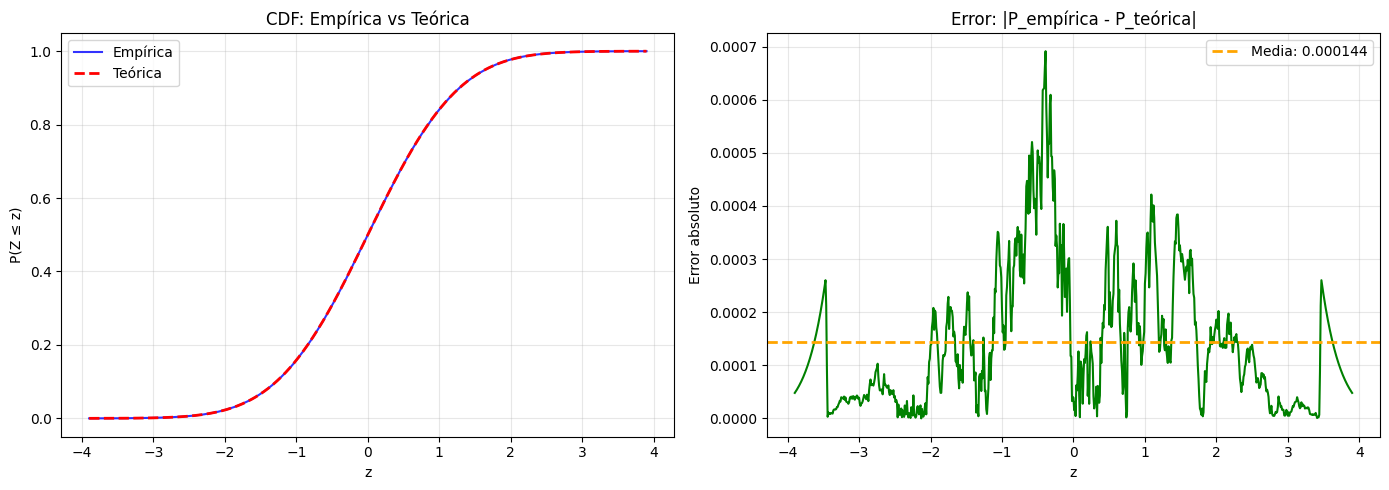

In [24]:

tabla = generar_tabla_normal(muestras)

# Estadísticas
print(f"Error máximo:   {tabla['error'].max():.6f}")
print(f"Error promedio: {tabla['error'].mean():.6f}\n")

# Visualizar
visualizar_tabla(tabla)
guardar_tabla_clasica(tabla)